# EDA Données Scraping TV et Webpress

Les données sont divisées en deux catégories : TV et Webpress.

TV :
- BFMTV
- FranceTvInfo

Webpress :
- 20 Minutes
- Le Point
- Le Figaro
- Le Monde
- L'Express
- Libération
- Nouvel Obs

Les Fichiers sont au format Parquet.

In [1]:
base_path = '../data_public/sitemap_dumps/'

# Import des librairies
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# créer deux listes contenant les noms des fichiers scrappés
tv_sources = os.listdir(base_path+'media_type=tv')
webpress_sources = os.listdir(base_path+'media_type=webpress')
filelist_tv = []
for source in tv_sources:
    for root, dirs, files in os.walk(base_path+'media_type=tv/'+source):
	    for file in files:
            #append the file name to the list
		    filelist_tv.append(os.path.join(root,file))

filelist_webpress = []
for source in webpress_sources:
    for root, dirs, files in os.walk(base_path+'media_type=webpress/'+source):
        for file in files:
            #append the file name to the list
            filelist_webpress.append(os.path.join(root,file))


In [2]:
#  Importer les fichiers parquet dans un dataframe pandas
df_tv = pd.DataFrame()
for file in filelist_tv:
    df_tv = df_tv.append(pd.read_parquet(file, engine='pyarrow'))

df_webpress = pd.DataFrame()
for file in filelist_webpress:
    df_webpress = df_webpress.append(pd.read_parquet(file, engine='pyarrow'))

In [3]:
# Vérifier la taille des dataframes
print('Taille du dataframe TV : ', df_tv.shape)
print('Taille du dataframe Webpress : ', df_webpress.shape)

Taille du dataframe TV :  (19427, 19)
Taille du dataframe Webpress :  (27017, 24)


In [4]:
# Concaténer les deux dataframes

df = pd.concat([df_tv, df_webpress], axis=0)

In [5]:
# vérifier les pourcentages de valeurs manquantes par colonnes
print('Pourcentage de valeurs manquantes par colonnes pour le dataframe : ')
print(df.isnull().sum()/df.shape[0]*100)

Pourcentage de valeurs manquantes par colonnes pour le dataframe : 
url                       0.000000
publication_name          0.000000
publication_language      0.000000
news_publication_date     0.000000
news_title                0.000000
image_loc                 1.694514
image_caption             8.705107
sitemap                   0.000000
sitemap_size_mb           0.000000
download_date             0.000000
media                     0.000000
section                   0.000000
media_type               75.983981
news                     56.982603
news_publication         56.982603
image                    57.490742
news_keywords            65.608044
etag                     75.669624
sitemap_last_modified    54.207217
lastmod                  57.908449
news_genres              99.829903
news_access              99.608130
changefreq               95.047800
priority                 95.047800
dtype: float64


In [6]:
# Taille du dataframe final :
print('Taille du dataframe final : ', df.shape)

Taille du dataframe final :  (46444, 24)


In [7]:
# Supprimer les colonnes avec plus de 50% de valeurs manquantes
df = df.dropna(axis=1, thresh=df.shape[0]*0.5)

# Print les doublons dans `news_title`
print('Nombre de doublons dans news_title : ', df['news_title'].duplicated().sum())

# Supprimer les doublons dans `news_title`
df = df.drop_duplicates(subset=['news_title'])

# Remove all dates matching the pattern `\d{2}\/\d{2}` in news_title
df['news_title'] = df['news_title'].apply(lambda x: re.sub(r'\d{2}\/\d{2}', '', x))

# convertir la colonne section de type array en type list
df['section'] = df['section'].apply(lambda x: x.tolist())

# Chercher les bulletins météos dans la colonne section
df['is_weather'] = df['section'].apply(lambda x: 'meteo' in x)
print('Pourcentage de bulletins météos dans le dataframe : ')
print(df['is_weather'].sum()/df.shape[0]*100)

# Chercher les articles ayant 'JT' dans le titre
df['is_jt'] = df['news_title'].apply(lambda x: 'JT' in x)
print('Pourcentage d\'articles ayant "JT" dans le titre : ')
print(df['is_jt'].sum()/df.shape[0]*100)

# Print le nombre d'articles à supprimer
print('Nombre d\'articles à supprimer : ', df[(df['is_weather'] == True) | (df['is_jt'] == True)].shape[0])

# Supprimer les articles ayant is_weather = True ou is_jt = True
df = df[(df['is_weather'] == False) & (df['is_jt'] == False)]

Nombre de doublons dans news_title :  20017
Pourcentage de bulletins météos dans le dataframe : 
1.4114352745298369
Pourcentage d'articles ayant "JT" dans le titre : 
0.07189616679910697
Nombre d'articles à supprimer :  392


In [8]:
# Shuffle le dataframe

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
# Extraire article news titles du dataframe en ajoutant toutes les catégories de la colonne section

titles = []
for i in range(df.shape[0]):
    titles.append(df['news_title'][i] + ' ' + '--' + ' ' + ' '.join(cat for cat in df['section'][i]))

#titles = df['news_title'].tolist()

In [10]:
# Importer les librairies pour le traitement du texte
import gensim
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(42)

import nltk
nltk.download('wordnet')

# import french stopwords

from nltk.corpus import stopwords
stop_words = stopwords.words('french')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\renar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# Create stemmer

stemmer = SnowballStemmer("french")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize

def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [12]:
# Preview a document after preprocessing

doc_sample = titles[0]

print('Original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('Tokenized and lemmatized document: ')
print(preprocess(doc_sample))

Original document: 
['La', 'présidente', 'du', 'Pérou', 'a', 'nommé', 'son', 'gouvernement', '--', 'unknown']
Tokenized and lemmatized document: 
['président', 'pérou', 'nomm', 'gouvern', 'unknown']


In [13]:
# Preprocess the news titles and save them to a list

processed_titles = []
for title in titles:
    processed_titles.append(preprocess(title))


In [14]:
# Create a bag of words

dictionary = gensim.corpora.Dictionary(processed_titles)

In [15]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 gouvern
1 nomm
2 président
3 pérou
4 unknown
5 adhérent
6 décembr
7 polit
8 pourront
9 républicain
10 vot


In [16]:
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=100000)

In [17]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_titles]

In [18]:
bow_doc = bow_corpus[0]
for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0], 
                                                     dictionary[bow_doc[i][0]], 
                                                     bow_doc[i][1]))

Word 0 ("gouvern") appears 1 time.
Word 1 ("nomm") appears 1 time.
Word 2 ("président") appears 1 time.
Word 3 ("pérou") appears 1 time.
Word 4 ("unknown") appears 1 time.


In [19]:
# TF-IDF
from gensim import corpora, models


tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3656773552102382),
 (1, 0.5285292813753664),
 (2, 0.33972463506343126),
 (3, 0.4933338405077469),
 (4, 0.47764606640919716)]


In [20]:
# LDA en utilisant le bag of words

lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=20, 
                                       id2word = dictionary, 
                                       passes = 2
                                       )

In [21]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(topic, idx ))
    print("\n")

Topic: 0.017*"international" + 0.014*"azur" + 0.013*"cot" + 0.013*"articl" + 0.011*"planet" + 0.011*"flash" + 0.011*"chin" + 0.010*"apres" + 0.009*"nic" + 0.009*"actu" 
Words: 0


Topic: 0.074*"coup" + 0.038*"sport" + 0.029*"football" + 0.015*"articl" + 0.013*"lyon" + 0.011*"polit" + 0.011*"apres" + 0.010*"final" + 0.009*"fac" + 0.008*"argentin" 
Words: 1


Topic: 0.056*"marseil" + 0.016*"bonsoir" + 0.014*"fait" + 0.012*"apres" + 0.009*"plus" + 0.009*"diver" + 0.009*"lyon" + 0.009*"normand" + 0.008*"bonjour" + 0.008*"polit" 
Words: 2


Topic: 0.044*"econom" + 0.014*"entrepris" + 0.010*"articl" + 0.009*"coup" + 0.009*"societ" + 0.009*"sport" + 0.007*"plus" + 0.007*"alsac" + 0.007*"flash" + 0.007*"fair" 
Words: 3


Topic: 0.033*"coup" + 0.013*"tech" + 0.013*"sport" + 0.013*"lill" + 0.010*"cultur" + 0.010*"noël" + 0.010*"bon" + 0.010*"articl" + 0.010*"plan" + 0.010*"football" 
Words: 4


Topic: 0.024*"azur" + 0.022*"cot" + 0.018*"econom" + 0.015*"societ" + 0.015*"articl" + 0.012*"internat

In [22]:
# LDA en utilisant TF-IDF

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                       num_topics=20, 
                                       id2word = dictionary, 
                                       passes = 2
                                       )

In [23]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))
    print("\n")

Topic: 0 Word: 0.009*"econom" + 0.009*"coup" + 0.007*"societ" + 0.006*"articl" + 0.006*"actualit" + 0.005*"apres" + 0.005*"hôpital" + 0.004*"cultur" + 0.004*"cyberattaqu" + 0.004*"paris"


Topic: 1 Word: 0.016*"lyon" + 0.010*"paris" + 0.007*"international" + 0.007*"chin" + 0.006*"econom" + 0.006*"russ" + 0.006*"articl" + 0.006*"ukrain" + 0.006*"sport" + 0.006*"cultur"


Topic: 2 Word: 0.012*"coup" + 0.010*"articl" + 0.006*"econom" + 0.006*"societ" + 0.006*"polit" + 0.005*"flash" + 0.005*"apres" + 0.005*"cultur" + 0.005*"sant" + 0.004*"retour"


Topic: 3 Word: 0.008*"tech" + 0.007*"livr" + 0.007*"sport" + 0.007*"articl" + 0.006*"rugby" + 0.006*"plan" + 0.006*"cultur" + 0.006*"paris" + 0.006*"econom" + 0.005*"bon"


Topic: 4 Word: 0.007*"polit" + 0.007*"paris" + 0.006*"alsac" + 0.005*"econom" + 0.005*"coup" + 0.005*"sport" + 0.005*"societ" + 0.005*"normand" + 0.005*"contr" + 0.004*"international"


Topic: 5 Word: 0.008*"livr" + 0.008*"polit" + 0.007*"ukrain" + 0.007*"sant" + 0.006*"inter

In [24]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "here's": "here is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]    
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer;
texts = processed_titles

tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.80,
    max_features=6000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)
tfidf = tfidf_vectorizer.fit_transform(texts)

tfidf_fn = tfidf_vectorizer.get_feature_names()

In [26]:
from sklearn.decomposition import NMF;

# Run the NMF model
nmf = NMF(
    n_components=40,
    init='nndsvda'    
).fit(tfidf)

docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 6

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) 
topic_df['topics'] = topic_df['topics'].str[0]  
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x))
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  
topic_df['topics'] = topic_df['topics'].str[0] 

topic_df.head(15)

,0,1,2,3,4,5,topics
0,coup mond,coup,mond,football coup,football,sport football,coup mond football sport
1,marseil,marseil replay,bonjour marseil,bonsoir marseil,emiss bonjour,bonjour,marseil replay bonjour bonsoir emiss
2,ukrain,guerr,guerr ukrain,europ,mond europ,manifest ukrain,ukrain guerr europ mond manifest
3,tech,plan,bon,bon plan,tech bon,prix,tech plan bon prix
4,azur,cot azur,cot,azur replay,nic,bonjour cot,azur cot replay nic bonjour
5,bours,econom replay,emiss bours,econom,replay emiss,emiss,bours econom replay emiss
6,lyon,lyon replay,bonjour lyon,bonsoir lyon,rhôn,emiss lyon,lyon replay bonjour bonsoir rhôn emiss
7,franc,maroc,franc maroc,replay franc,final,heur,franc maroc replay final heur
8,paris,paris replay,bonjour paris,bonsoir paris,emiss paris,emiss bonjour,paris replay bonjour bonsoir emiss
9,lill,grand,grand lill,lill replay,bonjour lill,bonsoir lill,lill grand replay bonjour bonsoir


In [27]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.80,
    keep_n=6000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 100 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

KeyboardInterrupt: 

In [ ]:
from operator import itemgetter

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

100


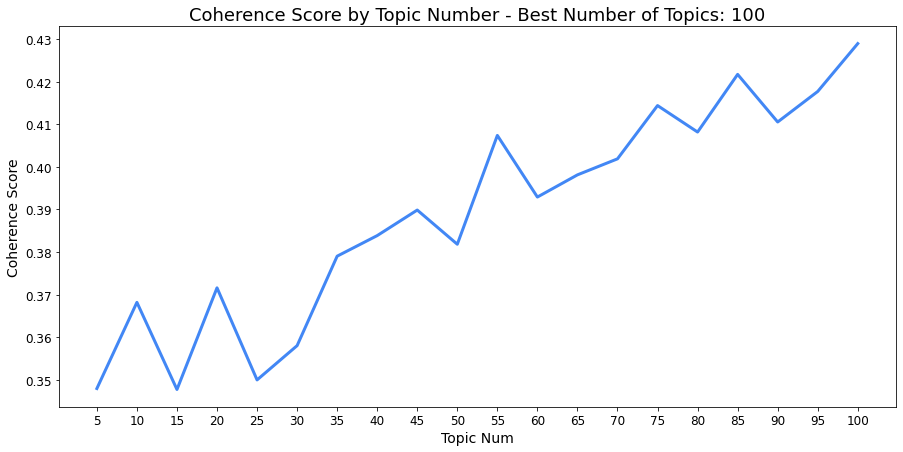

In [ ]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

file_name = 'c_score'

plt.show()

In [ ]:
# Run the nmf model with the best number of topics

# Run the NMF model
nmf = NMF(
    n_components=55,
    init='nndsvda'    
).fit(tfidf)

docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 6

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) 
topic_df['topics'] = topic_df['topics'].str[0]  
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x))
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  
topic_df['topics'] = topic_df['topics'].str[0] 

topic_df.head(15)

,0,1,2,3,4,5,topics
0,mond,coup,coup mond,bleus,qatar,croat,mond coup bleus qatar croat
1,franc,angleterr,franc angleterr,pologn,franc pologn,angleterr franc,franc angleterr pologn
2,ukrain,guerr,guerr ukrain,poutin,kiev,zelensky,ukrain guerr poutin kiev zelensky
3,électr,coupur,coupur électr,hiv,électr hiv,délestag,électr coupur hiv délestag
4,état,état unis,unis,macron état,europ,visit,état unis macron europ visit
5,décembr,météo,prévis,vendred,dimanch,samed,décembr météo prévis vendred dimanch samed
6,noël,march,march noël,sapin,sapin noël,strasbourg,noël march sapin strasbourg
7,apres,apres avoir,trois,avoir,victoir,apres victoir,apres avoir trois victoir
8,retrait,réform,réform retrait,bear,janvi,report,retrait réform bear janvi report
9,européen,parl,parl européen,corrupt,soupçon,soupçon corrupt,européen parl corrupt soupçon


In [ ]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()
# Creating a temp df with the url and topic num to join on
body = df['news_title'].tolist()

df_temp = pd.DataFrame({
    'body': body,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)
pd.set_option('display.max_colwidth', None)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    left_on='news_title',
    right_on='body',
    how='left'
)

<AxesSubplot:>

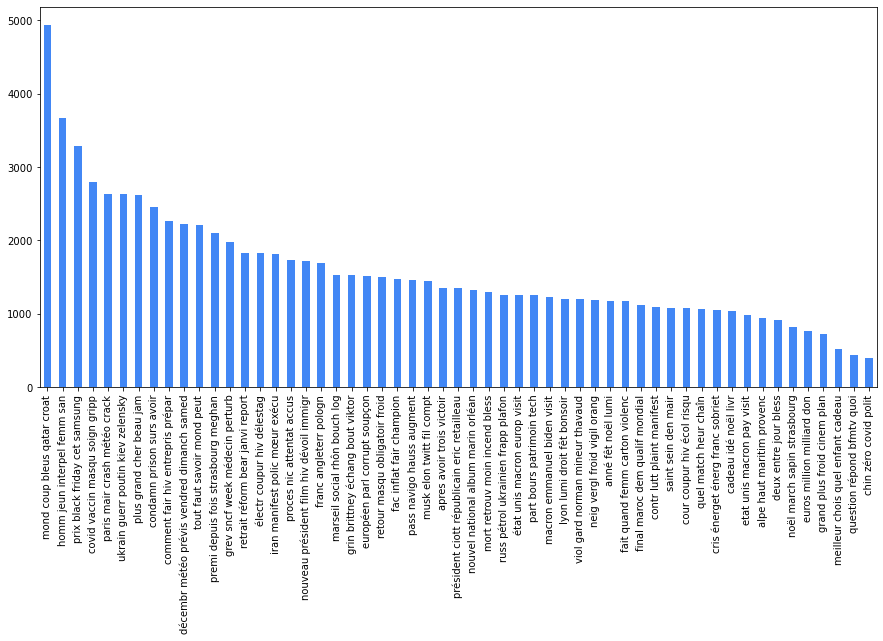

In [ ]:
# plot the number of articles per topic

fig = plt.figure(figsize=(15, 7))

df_topics['topics'].value_counts().plot(
    kind='bar',
    color='#4287f5'
)